# Preprocess data

In [196]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
imp

## Read in all datasets into dictionary
All the nine seperate csv files are saved locally due to their size (total 120 MB). They are read into a dictionary.

In [187]:
from olist.data import get_data, transform_datetime, data_cleaning_general
from olist.merge import orders_order_reviews

In [3]:
data = get_data()

In [4]:
list(data.keys())

['sellers',
 'order_reviews',
 'order_items',
 'customers',
 'orders',
 'order_payments',
 'product_category_name_translation.csv',
 'products',
 'geolocation']

## Number of observations

In [5]:
for name in data.keys():
    print(name)
    print(data[name].count())
    print("------------------------------")

sellers
seller_id                 3095
seller_zip_code_prefix    3095
seller_city               3095
seller_state              3095
dtype: int64
------------------------------
order_reviews
review_id                  99224
order_id                   99224
review_score               99224
review_comment_title       11568
review_comment_message     40977
review_creation_date       99224
review_answer_timestamp    99224
dtype: int64
------------------------------
order_items
order_id               112650
order_item_id          112650
product_id             112650
seller_id              112650
shipping_limit_date    112650
price                  112650
freight_value          112650
dtype: int64
------------------------------
customers
customer_id                 99441
customer_unique_id          99441
customer_zip_code_prefix    99441
customer_city               99441
customer_state              99441
dtype: int64
------------------------------
orders
order_id                         99441

There seem to be around 99 k orders and customers. 
Number of rows in geolocation seems strange as there are only 3 k sellers, but more than 1000 k rows in geolocation. 

## Duplicates

In [6]:
for name in data.keys():
    print(name)
    print(data[name].duplicated().sum())
    print("------------------------------------")

sellers
0
------------------------------------
order_reviews
0
------------------------------------
order_items
0
------------------------------------
customers
0
------------------------------------
orders
0
------------------------------------
order_payments
0
------------------------------------
product_category_name_translation.csv
0
------------------------------------
products
0
------------------------------------
geolocation
261831
------------------------------------


The only dataset with duplicates is geolocation. 

## Missing data

In [7]:
## Check for missing values
for name in data.keys():
    print(name)
    print(data[name].isna().sum())
    print("----------------------------")

sellers
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
----------------------------
order_reviews
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
----------------------------
order_items
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
----------------------------
customers
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
----------------------------
orders
order_id                            0
customer_id                         0
order_status                        0

We will look at the datasets with missing values (order_reviews, orders and products) individually. 

### Orders 

In [8]:
orders = data["orders"]
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [10]:
orders[orders.order_status != "delivered"].isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1781
order_delivered_customer_date    2957
order_estimated_delivery_date       0
dtype: int64

In [11]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

It seems that most of the missing values in order_approved_at, order_delivered_carrier_date and order_delivered_customer_date is due to orders that are not yet shipped.
If we only keep the delivered orders (for which we might have reviews) we get possibly rid of most NAs

### Order_reviews

In [12]:
data["order_reviews"].isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [13]:
cond = data["order_reviews"].review_comment_title.isna()
data["order_reviews"][cond][0:15]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
10,c9cfd2d5ab5911836ababae136c3a10c,cdf9aa68e72324eeb25c7de974696ee2,5,NaN,NaN,2017-12-23 00:00:00,2017-12-26 14:36:03


It seems that reviews with no title or no message are still valid reviews, so we leave them. 

### Products

In [14]:
data["products"].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [15]:
data["products"].isna().sum()


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [16]:
cond = data["products"].product_category_name.isna()

data["products"][cond][0:15]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
244,e10758160da97891c2fdcbc35f0f031d,NaN,NaN,NaN,NaN,2200.0,16.0,2.0,11.0
294,39e3b9b12cd0bf8ee681bbc1c130feb5,NaN,NaN,NaN,NaN,300.0,16.0,7.0,11.0
299,794de06c32a626a5692ff50e4985d36f,NaN,NaN,NaN,NaN,300.0,18.0,8.0,14.0
347,7af3e2da474486a3519b0cba9dea8ad9,NaN,NaN,NaN,NaN,200.0,22.0,14.0,14.0
428,629beb8e7317703dcc5f35b5463fd20e,NaN,NaN,NaN,NaN,1400.0,25.0,25.0,25.0


In [17]:
data["products"].count().max()

32951

Out of the 33 k products around 600 are missing a name and a description. As these are the most important columns, I will drop the missing rows. 

## Data cleaning pipeline

In [21]:
data = data_cleaning_general(data)

/home/jakob/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Exploratory Data Analysis

- How  many unique values do we have?
- Number of reviews per order?
- Reviews for all orders?
- Check the distribution of reviews
- Plot weekly number of orders
- Plot weekly turnover (price from order_items)
- Plot review_score over time

## Change datetime

In [20]:
data = transform_datetime(data)

/home/jakob/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## How many unique values do we have?

In [21]:
# unique values
for file in data.keys():
    print(file.upper())
    print(data[file].nunique())
    print("--------------------------------------------------------")

SELLERS
seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64
--------------------------------------------------------
ORDER_REVIEWS
review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64
--------------------------------------------------------
ORDER_ITEMS
order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64
--------------------------------------------------------
CUSTOMERS
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64
-----

- order_status could be dropped as we only have one left filtered out all non-delivered). I will keep it here for clarity.
- It's strange that we have only 3095 sellers with 2246 zip_code_prefixes but more than 70 k lat and long coordinates in geolocation dataset. If we want to use it, we might need to average the coordinates or something similar. 
- We got 73 different product_category_names but only 71 translations. 

## Number of Reviews per order? Reviews for all orders?

In [180]:
orders = data["orders"]
order_reviews = data["order_reviews"]

In [181]:
order_reviews["order_id"].duplicated().sum()

551

In [182]:
# Check for orders with more than one review
temp = order_reviews[["order_id", "review_id"]].groupby(by = "order_id").agg(["count"]).reset_index()

temp.columns = ["order_id", "review_id"]
temp.review_id[temp.review_id > 1].value_counts()

2    543
3      4
Name: review_id, dtype: int64

There seem to be around 540 orders with 2 reviews and 4 orders with 3 reviews. 

I create a list of all order_ids with two or more reviews

In [183]:
multi_reviews = list(temp["order_id"][temp.review_id > 1])

In [184]:
len(multi_reviews), len(set(multi_reviews))
# No duplicated order_ids in multi_reviews list

(547, 547)

I check whether the review_score for the same order_id is different for different review_ids. 

Therefore I create a df with only all orders with two or more reviews.

In [185]:
cond = orders_reviews_comb.order_id.isin(multi_reviews)

In [186]:
multi_reviews_df = orders_reviews_comb[cond]
multi_reviews_df.sort_values(by = "order_id").head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
88954,0035246a40f520710769010f752e7507,4bcf2ad7ccc061c13ff360aae5b7abcd,delivered,2017-08-17 00:57:23,2017-08-17 01:25:39,2017-08-22 15:33:53,2017-08-28 19:14:03,2017-09-06 00:00:00,2a74b0559eb58fc1ff842ecc999594cb,5.0,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
88955,0035246a40f520710769010f752e7507,4bcf2ad7ccc061c13ff360aae5b7abcd,delivered,2017-08-17 00:57:23,2017-08-17 01:25:39,2017-08-22 15:33:53,2017-08-28 19:14:03,2017-09-06 00:00:00,89a02c45c340aeeb1354a24e7d4b2c1e,5.0,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
82138,013056cfe49763c6f66bda03396c5ee3,d3d38825275e47847abef7e1936b3bcb,delivered,2018-02-14 12:48:24,2018-02-14 12:55:56,2018-02-15 20:32:36,2018-03-03 12:09:00,2018-03-07 00:00:00,ab30810c29da5da8045216f0f62652a2,5.0,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
82139,013056cfe49763c6f66bda03396c5ee3,d3d38825275e47847abef7e1936b3bcb,delivered,2018-02-14 12:48:24,2018-02-14 12:55:56,2018-02-15 20:32:36,2018-03-03 12:09:00,2018-03-07 00:00:00,73413b847f63e02bc752b364f6d05ee9,4.0,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
91871,0176a6846bcb3b0d3aa3116a9a768597,aaad67429ea7d339bdf5f71ae3ef74f6,delivered,2017-12-25 10:40:52,2017-12-27 04:32:07,2017-12-28 19:57:15,2017-12-29 21:22:35,2018-01-15 00:00:00,d8e8c42271c8fb67b9dad95d98c8ff80,5.0,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:47


For later investigation all orders with two or more reviews and with different review_scores in these reviews are saved in a csv file. 

In [112]:
multi_reviews_df.to_csv("orders_with_multiple_reviews.csv")

Then I group by order_id and put all values in review_score in a list. 

In [107]:
temp = pd.DataFrame(multi_reviews_df[["order_id", "review_id", "review_score"]].groupby(by = "order_id")["review_score"].apply(list))
temp.reset_index(inplace=True)
temp.head(5)

,order_id,review_score
0,0035246a40f520710769010f752e7507,"[5.0, 5.0]"
1,013056cfe49763c6f66bda03396c5ee3,"[5.0, 4.0]"
2,0176a6846bcb3b0d3aa3116a9a768597,"[5.0, 5.0]"
3,02355020fd0a40a0d56df9f6ff060413,"[1.0, 3.0]"
4,029863af4b968de1e5d6a82782e662f5,"[5.0, 4.0]"


In [71]:
temp = pd.DataFrame(temp.review_score.to_list(), columns = ["review_score_1", "review_score_2", "review_score_3"])

In [91]:
temp["no_diff"] = None

In [99]:
for ind, row in temp.iterrows(): 
    if np.isnan(row["review_score_3"]): 
        if row["review_score_1"] == row["review_score_2"]:
            temp.loc[ind, "no_diff"] = True 
        else: 
            temp.loc[ind, "no_diff"] = False
    else:
       
        if row["review_score_1"] == row["review_score_2"] == row["review_score_3"]:
            temp.loc[ind, "no_diff"] = True
        else: 
            temp.loc[ind, "no_diff"] = False

In [106]:
temp

,review_score_1,review_score_2,review_score_3,no_diff
0,5.0,5.0,NaN,True
1,5.0,4.0,NaN,False
2,5.0,5.0,NaN,True
3,1.0,3.0,NaN,False
4,5.0,4.0,NaN,False
...,...,...,...,...
542,5.0,5.0,NaN,True
543,5.0,5.0,NaN,True
544,3.0,5.0,NaN,False
545,5.0,5.0,NaN,True


In [113]:
# Orders with no review
orders_reviews_comb.isna().sum()

order_id                             0
customer_id                       2886
order_status                      2886
order_purchase_timestamp          2886
order_approved_at                 2886
order_delivered_carrier_date      2886
order_delivered_customer_date     2886
order_estimated_delivery_date     2886
review_id                            0
review_score                         0
review_comment_title             87656
review_comment_message           58247
review_creation_date                 0
review_answer_timestamp              0
dtype: int64

In [32]:
# We got 646 orders with no reviews, which we drop here for further analysis
orders_reviews_comb.dropna(subset=["review_id"], inplace=True)

To make the further analysis easier I will drop all orders with no reviews.
For the orders with multiple reviews the latest review is taken as the final review. This is done as we can assume that latest reviews is the best representation of the overall customer satisfaction.  

In [157]:
temp = pd.concat(g for _, g in order_reviews.groupby("order_id") if len(g) > 1).sort_values(by = ["order_id", "review_creation_date"], 
                                                                                    ascending=[True, False])["order_id"]

drop =  temp.duplicated(keep = "first")
drop_index = temp[drop].index
orders = orders[~ orders.index.isin(drop_index)]

In [189]:
orders_order_reviews(data)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95794,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,e262b3f92d1ce917aa412a9406cf61a6,5,NaN,NaN,2017-03-22 00:00:00,2017-03-23 11:02:08
95795,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,29bb71b2760d0f876dfa178a76bc4734,4,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01
95796,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,371579771219f6db2d830d50805977bb,5,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57
95797,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,8ab6855b9fe9b812cd03a480a25058a1,2,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56


## Check the distribution of reviews

In [213]:
order_reviews.review_score = order_reviews.review_score.astype("category")

order_reviews.review_score.value_counts(normalize=True).sort_index()

sns.histplot(x = "review_score", data = order_reviews);

<AxesSubplot:xlabel='Count', ylabel='review_score'>

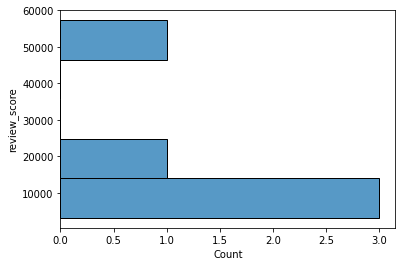

In [206]:
5-Star ratings account for almost 60 % of all ratings



sns.histplot(x= order_reviews.review_score.)